In [1]:
import os
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import classification_report

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
folder_path = '/content/drive/My Drive/data/cataract_data'


In [6]:
import tensorflow as tf

rescale = tf.keras.layers.Rescaling(1./255)


class_names = ['cataract', 'normal']

train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=folder_path,
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.2,
    subset="training",
    seed=123,
    label_mode='categorical',
    class_names=class_names  
)

train_ds = train_ds.map(lambda x, y: (rescale(x), y))

validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory=folder_path,
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.2,
    subset="validation",
    seed=123,
    label_mode='categorical',
    class_names=class_names  
)

validation_ds = validation_ds.map(lambda x, y: (rescale(x), y))

print("Datasets loaded from Google Drive.")


Found 2112 files belonging to 2 classes.
Using 1690 files for training.
Found 2112 files belonging to 2 classes.
Using 422 files for validation.
Datasets loaded from Google Drive.


In [7]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=folder_path,  
    batch_size=32,
    image_size=(256, 256),
    label_mode='categorical', 
    class_names=class_names, 
    shuffle=False, 
)

test_ds = test_ds.map(lambda x, y: (rescale(x), y))

print("Training, validation, and test datasets loaded and preprocessed.")

Found 2112 files belonging to 2 classes.
Training, validation, and test datasets loaded and preprocessed.


In [8]:
print("Shape of the first image in the training dataset:", next(iter(train_ds))[0][0].shape)
print("Shape of the first image in the validation dataset:", next(iter(validation_ds))[0][0].shape)
print("Shape of the first image in the test dataset:", next(iter(test_ds))[0][0].shape)

Shape of the first image in the training dataset: (256, 256, 3)
Shape of the first image in the validation dataset: (256, 256, 3)
Shape of the first image in the test dataset: (256, 256, 3)


In [9]:
min_pixel_value = float('inf')
max_pixel_value = float('-inf')

for images, _ in train_ds:
    batch_min = tf.reduce_min(images)
    batch_max = tf.reduce_max(images)

    min_pixel_value = tf.minimum(min_pixel_value, batch_min)
    max_pixel_value = tf.maximum(max_pixel_value, batch_max)

print("Minimum pixel value:", min_pixel_value.numpy())
print("Maximum pixel value:", max_pixel_value.numpy())

Minimum pixel value: 0.0
Maximum pixel value: 1.0


In [11]:
def visualize_images(path, target_size=(256, 256), num_images=5):

    image_filenames = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

    if not image_filenames:
        raise ValueError("No images found in the specified path")

    selected_images = random.sample(image_filenames, min(num_images, len(image_filenames)))

    fig, axes = plt.subplots(1, num_images, figsize=(15, 3), facecolor='white')

    for i, image_filename in enumerate(selected_images):
        image_path = os.path.join(path, image_filename)
        image = Image.open(image_path)
        image = image.resize(target_size)

        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(image_filename)  

    plt.tight_layout()
    plt.show()

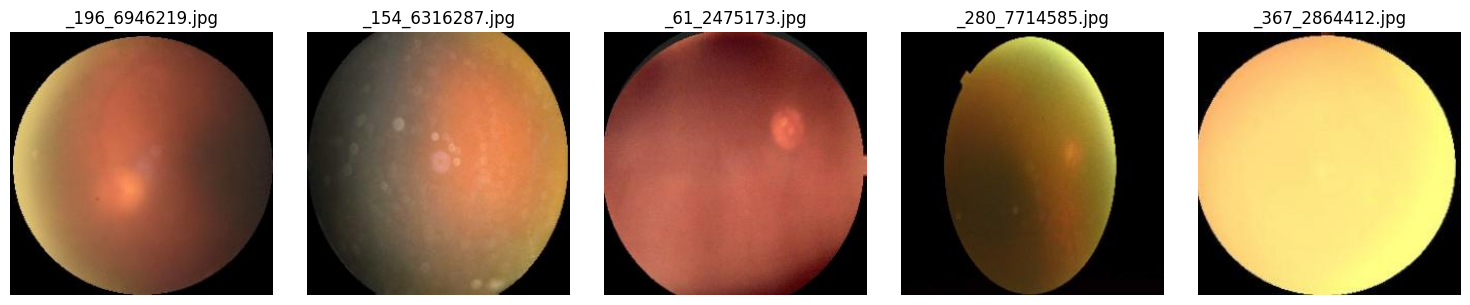

In [13]:
path_to_visualize = '/content/drive/My Drive/data/cataract_data/cataract'

visualize_images(path_to_visualize, num_images=5)

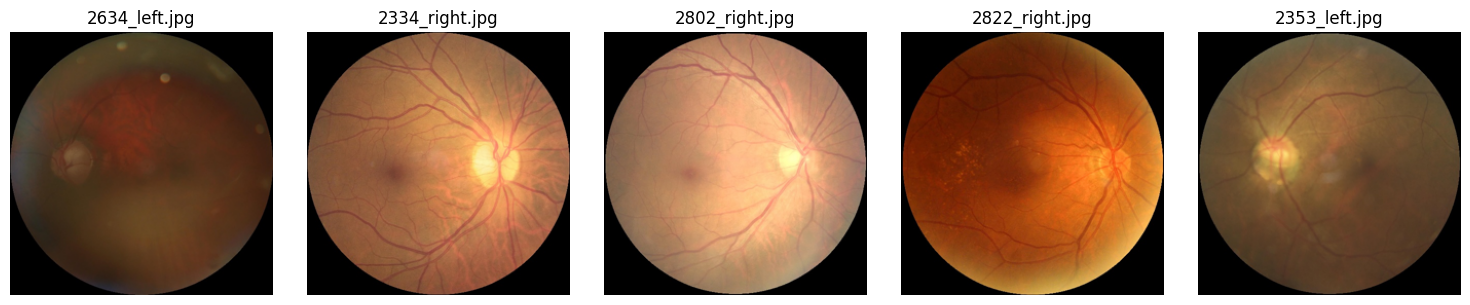

In [14]:
path_to_visualize = "/content/drive/My Drive/data/cataract_data/normal"

visualize_images(path_to_visualize, num_images=5)

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Reshape((64, 1)),  
    tf.keras.layers.SimpleRNN(32),  
    tf.keras.layers.Dense(2, activation='softmax')  
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(model.summary())


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       3,686,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 64, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 32)                  │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,743,938 (14.28 MB)

 Trainable params: 3,743,938 (14.28 MB)

 Non-trainable params: 0 (0.00 B)

None


In [16]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(train_ds,
                    validation_data=validation_ds,
                    epochs=5,
                    callbacks=[early_stopping])

Epoch 1/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 290s 5s/step - accuracy: 0.5701 - loss: 0.6899 - val_accuracy: 0.6114 - val_loss: 0.6207
Epoch 2/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 261s 5s/step - accuracy: 0.6509 - loss: 0.5983 - val_accuracy: 0.6919 - val_loss: 0.5833
Epoch 3/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 268s 5s/step - accuracy: 0.6702 - loss: 0.5835 - val_accuracy: 0.6825 - val_loss: 0.5819
Epoch 4/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 330s 5s/step - accuracy: 0.7025 - loss: 0.5531 - val_accuracy: 0.6919 - val_loss: 0.5588
Epoch 5/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 262s 5s/step - accuracy: 0.7312 - loss: 0.5147 - val_accuracy: 0.7014 - val_loss: 0.5734
